In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time
import simulation_functions as sfs

np.random.seed(42)

import importlib
importlib.reload(sfs)

<module 'simulation_functions' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/simulation_functions.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_ex5_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

bouttypes_allcond= ma.array(f['bout_types'])
stims_allcond = ma.array(f['stims'])
ecs_allcond = ma.array(f['eye_convergence'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
phi_smooth_allcond = ma.array(f['orientation_smooth'])
speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [3]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
ecs_allcond[ecs_allcond == 100] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','ChasingDot coarsespeeds(5x5cm)','ChasingDot finespeeds(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[515,525],[160,172],[87,148],[43,60],[22,43],[60,87],
                           [202,232],[148,160],[172,202],[505,515],[0,22],
                           [232,301],[347,445],[301,316],[316,347],
                           [445,505]])

In [5]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [6]:
recs_remove = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/recs_remove.npy')

In [7]:
recs_remove = np.hstack([recs_remove, np.arange(22,60)])

In [8]:
conditions = np.delete(conditions, recs_remove, axis=0)

In [9]:
print(recs_remove)

[ 90 260 264 270 276 352 358 364 375 381 383 392 398 404 410 416 422 427
 433 439 450 456 467 497  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59]


In [10]:
X_head_allcond = np.delete(X_head_allcond, recs_remove, axis=0)
X_head_allcond[X_head_allcond == 0] = ma.masked

time_Bout_allcond = np.delete(time_Bout_allcond,recs_remove, axis=0)
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

phi_smooth_allcond = np.delete(phi_smooth_allcond, recs_remove, axis=0)
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond = np.delete(speeds_head_allcond, recs_remove,axis=0)
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked

stims_allcond = np.delete(stims_allcond, recs_remove, axis=0)
stims_allcond[stims_allcond == 100] = ma.masked

ecs_allcond = np.delete(ecs_allcond, recs_remove, axis=0)
ecs_allcond[ecs_allcond == 100] = ma.masked

In [11]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

# lengths_all = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/lengths_ex2_recordings.npy')
# lengths_all = lengths

In [12]:
# recs_ = np.asarray(conditions[:,0], dtype=int)

to_mask = 1300

# maxL = np.max(lengths_all[recs_])
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked

# labels_fishrec = to_mask * ma.ones((len(recs_), maxL))
# labels_fishrec = labels_fish_allrec[recs_,:maxL+2]
# labels_fishrec = np.delete(labels_fishrec,4,0)

# labels_fishrec[labels_fishrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

# lengths_rem = np.delete(lengths_all, recs_remove)
lengths_rem = lengths_all

In [13]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [14]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [15]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [16]:
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

3


In [17]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [18]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

In [19]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg2_labels.npy')
kmeans_labels = kms
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

## Prey Capture hunting rates

In [383]:
cond = 15

pc_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(pc_recs)

maxL = np.max(lengths_rem[pc_recs])
lengths = lengths_rem[pc_recs]

[387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442]


In [384]:
time_Bout = time_Bout_allcond[pc_recs,:maxL,:]
ecs_pc = ecs_allcond[pc_recs,:maxL]

In [385]:
print(time_Bout.shape)
print(ecs_pc.shape)

(56, 2305, 2)
(56, 2305)


In [386]:
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[pc_recs]

In [387]:
print(np.unique(tmspace_clusters))

[0 5 6]


In [388]:
posterior = np.load('/Users/gautam.sridhar/Documents/ZENITH/Figures/posterior_f.npy')[pc_recs]
post_f = posterior/posterior.sum(axis=0)

In [389]:
print(post_f.shape)

(56, 7)


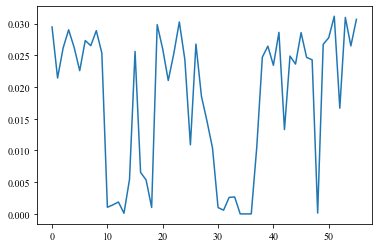

In [390]:
plt.plot(post_f[:,6])

0.02198577359546758 0.23556194441603617 0.2749514377872319
0.04506281507388 0.23556194441603617 0.2749514377872319
0.08664622634511077 0.23556194441603617 0.2749514377872319


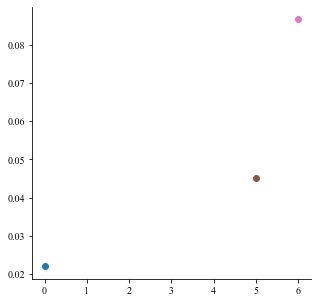

In [391]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for clus in [0,5,6]:
    hunt_num = 0.0
    for  cf in range(len(pc_recs)):
        if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
            hunt_num += post_f[cf,clus]*(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
    
    print(hunt_num, cil,ciu)
    ax.scatter(clus, hunt_num,c='C{}'.format(clus))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

0
0.022085736133775895 0.020125141615169744 0.026077285855409225
5
0.04545856002100253 0.036630239388399606 0.058229253820704055
6
0.086780147181933 0.0679633529695132 0.10671522908558707


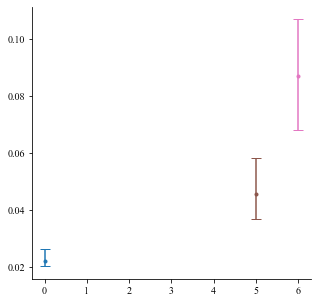

In [394]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for clus in [0,5,6]:
    print(clus)
    hunt_rats = []
    for i in range(100):
        hunt_num = []
        recs_ = np.random.choice(np.arange(len(pc_recs)),len(pc_recs),replace=True, p=post_f[:,clus])
        for cf in recs_:
            if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
                hunt_num.append(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
        hunt_rats.append(np.mean(hunt_num))
    m = np.mean(hunt_rats)
    cil = np.nanpercentile(hunt_rats, 2.5)
    ciu = np.nanpercentile(hunt_rats, 97.5)
    ax.errorbar(clus, m, np.asarray([np.asarray(m-cil), np.asarray(ciu-m)])[:,np.newaxis],fmt='.', capsize=5, color='C{}'.format(clus))
    m_pc.append(m)
    cil_pc.append(cil)
    ciu_pc.append(ciu)
    
    print(m, cil,ciu)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(0,8.5)
# ax.set_xlabel('Clusters',fontsize=35)
# ax.set_ylabel('EC events/min',fontsize=35)
# plt.yticks(fontsize=30)
# plt.xticks(rotation=70)
# fig.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig6/LRW_ec_perc_ha.pdf')

## Expanding spot responses

In [148]:
cond = 2
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(cond_recs)

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_rem[cond_recs])

Looming(5x5cm)
[ 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108]


In [149]:
print(maxL)

time_Bout = time_Bout_allcond[cond_recs,:maxL]
X_head = X_head_allcond[cond_recs,:maxL]

stims = stims_allcond[cond_recs, :maxL]
bouttypes = bouttypes_allcond[cond_recs, :maxL]

5959


In [150]:
cond = 2
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
print(cluster_fish_condition.shape)

Looming(5x5cm)
(60, 5959)


In [151]:
# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_rem[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

dtrajs_condition_phi1 = dtrajs_fish_phi1[cond_recs,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[cond_recs,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(60, 5959)


In [152]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmloom_stims.h5','r')
lengths_time = np.array(f['MetaData/lengths_data'], dtype=int)
stim_number_time = ma.array(f['stims'])
f.close()

stim_number_time = np.delete(stim_number_time, 4, axis=0)
stim_number_time[stim_number_time==100.] = ma.masked

In [153]:
stims_ = copy.deepcopy(stims)
stims_[stims_ == 100] = ma.masked

stims_all = ma.concatenate(stims_,axis=0)
stims_all[stims_all == 100.] = ma.masked

len(np.where(stims_all.compressed()==2.)[0])
stim_labels = ma.unique(stims_)[:-1]

In [154]:
print(stim_labels)

[-1.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0
 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0
 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0
 43.0 44.0 45.0 46.0 47.0]


In [155]:
stim_group1 = stim_labels[1::2]
stim_group2 = stim_labels[0::2]

In [156]:
# Convert all and project to time

# bouttypes[bouttypes == 15] = ma.masked
# stim_number = stims
# stim_number[stim_number == 100] = ma.masked

cluster_fish_condition_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
# labels_fish_condition_time = to_mask*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
dtrajs_fish_phi1_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
dtrajs_fish_phi2_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
# dtrajs_fish_phi3_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
# bouttypes_time = (ma.max(bouttypes)+1.)*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
# meanspeeds_time = ma.zeros((cluster_fish_condition.shape[0],int(time_Bout.max())))
# stim_number_time = (np.max(stim_labels)+1.)*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
for cf in range(cluster_fish_condition.shape[0]):
    for ks in np.unique(cluster_traj_all.compressed()):
        print(ks, cf)
        sel = cluster_fish_condition[cf] == ks
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        for segment in segments:
            t0,tf = segment
            for t in np.arange(t0,tf):
                fstart_bout_now, fstart_bout_next = int(time_Bout[cf,t,0])-1, int(time_Bout[cf,t+1,0])-1
                cluster_fish_condition_time[cf,fstart_bout_now-1:fstart_bout_next-1] = cluster_fish_condition[cf,t]
#                 labels_fish_condition_time[cf,fstart_bout_now-1:fstart_bout_next-1] = labels_fish_condition[cf,t]
                dtrajs_fish_phi1_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi1[cf,t]
                dtrajs_fish_phi2_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi2[cf,t]
#                 dtrajs_fish_phi3_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi3[cf,t]
#                 bouttypes_time[cf,fstart_bout_now-1:fstart_bout_next-1] = bouttypes[cf,t]
#                 meanspeeds_time[cf,fstart_bout_now-1:fstart_bout_next-1] = meanspeeds_fish[cf,t]

cluster_fish_condition_time[cluster_fish_condition_time == 5.] = ma.masked
dtrajs_fish_phi1_time[dtrajs_fish_phi1_time == 5.] = ma.masked
dtrajs_fish_phi2_time[dtrajs_fish_phi2_time == 5.] = ma.masked
# dtrajs_fish_phi3_time[dtrajs_fish_phi3_time == 5.] = ma.masked
# labels_fish_condition_time[labels_fish_condition_time == to_mask] = ma.masked
# bouttypes_time[bouttypes_time == ma.max(bouttypes)+1.] = ma.masked
# meanspeeds_time[meanspeeds_time==0] = ma.masked

from scipy.signal import decimate

dtrajs_phi1_timelist = [dtrajs_fish_phi1_time[i].compressed() for i in range(dtrajs_fish_phi1_time.shape[0])]
dtrajs_phi2_timelist = [dtrajs_fish_phi2_time[i].compressed() for i in range(dtrajs_fish_phi2_time.shape[0])]
cluster_timelist = [cluster_fish_condition_time[i].compressed() for i in range(cluster_fish_condition_time.shape[0])]


dtrajs_phi1_timedecim = []
dtrajs_phi2_timedecim = []

cluster_timedecim = []
# stims_timedecim = []

for i in range(len(dtrajs_phi1_timelist)):
    dtrajs_phi1_timedecim.append(decimate(decimate(decimate(dtrajs_phi1_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
    dtrajs_phi2_timedecim.append(decimate(decimate(decimate(dtrajs_phi2_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
    
    cluster_timedecim.append(decimate(decimate(decimate(cluster_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
#     stims_timedecim.append(decimate(decimate(decimate(stim_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3
0 4
1 4
0 5
1 5
0 6
1 6
0 7
1 7
0 8
1 8
0 9
1 9
0 10
1 10
0 11
1 11
0 12
1 12
0 13
1 13
0 14
1 14
0 15
1 15
0 16
1 16
0 17
1 17
0 18
1 18
0 19
1 19
0 20
1 20
0 21
1 21
0 22
1 22
0 23
1 23
0 24
1 24
0 25
1 25
0 26
1 26
0 27
1 27
0 28
1 28
0 29
1 29
0 30
1 30
0 31
1 31
0 32
1 32
0 33
1 33
0 34
1 34
0 35
1 35
0 36
1 36
0 37
1 37
0 38
1 38
0 39
1 39
0 40
1 40
0 41
1 41
0 42
1 42
0 43
1 43
0 44
1 44
0 45
1 45
0 46
1 46
0 47
1 47
0 48
1 48
0 49
1 49
0 50
1 50
0 51
1 51
0 52
1 52
0 53
1 53
0 54
1 54
0 55
1 55
0 56
1 56
0 57
1 57
0 58
1 58
0 59
1 59


In [157]:
dir2stim_group = [9.0,11.0,13.0,15.0]

4 3.9714285714285715
10 0.9814285714285714
26 10.005714285714285
27 10.01
48 10.077142857142857
(301, 28012)


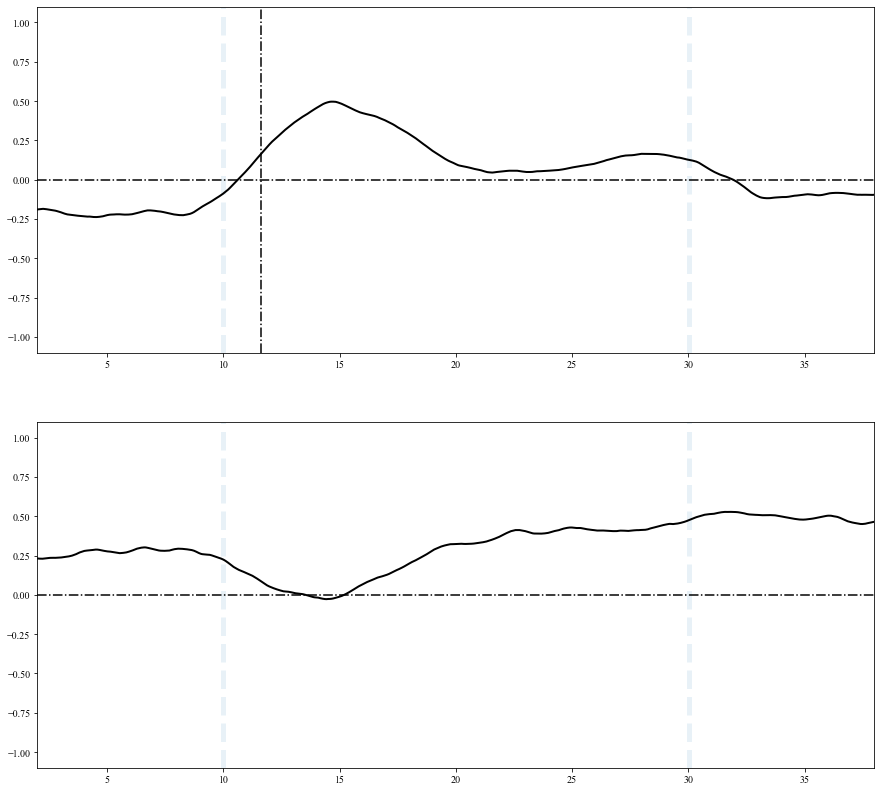

In [158]:
## Average response
from scipy import signal

fig, ax = plt.subplots(2,1,figsize=(15,14))
colors_ = plt.cm.viridis(np.linspace(0,1,len(dir2stim_group)))
    
phi1s_stimlist = []
phi2s_stimlist = []
clusters_stimlist = []
stims_stimlist = []

for k,stim in enumerate(dir2stim_group):
    stim_number = stim
    for i, rec in enumerate(np.arange(60)):
        sel = stim_number_time[rec] == stim_number
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        if len(segments) == 0:
            continue
        sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]

        for idx in sorted_indices[:]:
            st,en = segments[idx]
    #         print((en - st)/700)

            if (en-st)/700 <19 or (en-st)/700 > 22:
                print(i, (en-st)/700)
                continue
                
            win_start = 10*700
#             st = en - win_start
            win_end = 10*700

            dur_stim = en - st
            dur_tot = (en+win_end) - (st-win_start)

            ss_ = np.zeros((dur_tot,))
            ss_[win_start:win_start+(dur_stim)] = 1.
    #         ss_[0:dur_stim] = 1.

            st = st-win_start
            en = en+win_end

            phi1s = dtrajs_fish_phi1_time[rec][st:en]
            phi2s = dtrajs_fish_phi2_time[rec][st:en]

            if phi1s.shape[0] != ss_.shape[0]:
                print(st, en)
                print(i)
                print(phi2s.shape)
                print(ss_.shape)
                continue
            phi1s_stimlist.append(phi1s)
            phi2s_stimlist.append(phi2s)
            stims_stimlist.append(ss_)
            sts = cluster_fish_condition_time[rec][st:en]

phi1s_stimarr = 5*ma.ones((len(phi1s_stimlist), np.max([len(p) for p in phi1s_stimlist])))
phi2s_stimarr = 5*ma.ones((len(phi2s_stimlist), np.max([len(p) for p in phi2s_stimlist])))
print(phi2s_stimarr.shape)

win = np.ones((1*700,))/(1*700)
for i,p in enumerate(phi1s_stimlist):
    phi1s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')

for i,p in enumerate(phi2s_stimlist):
    phi2s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')

phi1s_stimarr[phi1s_stimarr == 5.] = ma.masked
m_phi1, cil_phi1, ciu_phi1 = stats.bootstrap(phi1s_stimarr, n_times = 10)

phi2s_stimarr[phi2s_stimarr == 5.] = ma.masked
m_phi2, cil_phi2, ciu_phi2 = stats.bootstrap(phi2s_stimarr, n_times = 10)

from matplotlib.collections import LineCollection
# divnorm = plt.Normalize(-1,1)

x = np.arange(0,len(m_phi2)-300)/700

ax[0].plot(x,m_phi1[:-300],color='k', lw=2, alpha=1., zorder=10)
ax[1].plot(x,m_phi2[:-300],color='k', lw=2, alpha=1., zorder=10)

# ax[0].fill_between(np.arange(0,len(m_phi1)-300)/700, cil_phi1[:-300], ciu_phi1[:-300], color='k', alpha=0.3, zorder=10)
# ax[1].fill_between(np.arange(0,len(m_phi2)-300)/700, cil_phi2[:-300], ciu_phi2[:-300], color='k', alpha=0.3, zorder=10)

# for i in np.arange(len(stims_stimlist)):
up_idx = np.where(ma.diff(stims_stimlist[0]) == 1)[0]
down_idx = np.where(ma.diff(stims_stimlist[0]) == -1)[0]
ax[0].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
ax[0].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

ax[1].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
ax[1].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

ax[0].axhline(0,color='k',ls='-.')
ax[0].axvline(11.6,color='k',ls='-.')
ax[0].set_ylim(-1.1,1.1)
ax[1].axhline(0,color='k',ls='-.')
ax[1].set_ylim(-1.1,1.1)
# ax.set_xlim(-1,30)

ax[0].set_ylim(-1.1,1.1)
ax[0].set_xlim(2,38)
# ax[0].axis('off')
# ax[1].axhline(0,color='k',ls='-.')
ax[1].set_ylim(-1.1,1.1)
ax[1].set_xlim(2,38)
# ax[1].axis('off')
fig.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/Expspot_avg_resp.pdf')

### Behavioral group responses

In [172]:
condition_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[cond_recs]

In [173]:
print(np.unique(tmspace_clusters))
# tmspace_clusters[tmspace_clusters == 3] = 7
# tmspace_clusters[tmspace_clusters == 4] = 7

[0 1 2 3 4 5]


2 0.9814285714285714
10 10.005714285714285
11 10.01
21 10.077142857142857
(139, 28012)
(79, 28011)
2 3.9714285714285715
(61, 28011)
(10, 28010)
(7, 28011)


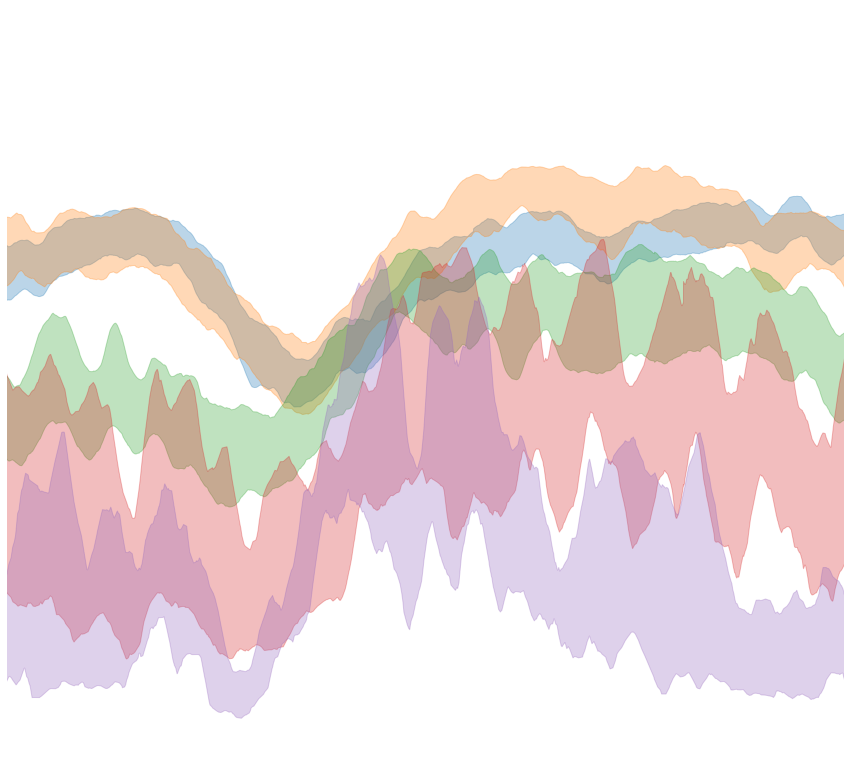

In [174]:
fig, ax = plt.subplots(1,1,figsize=(15,14))
colors_ = plt.cm.viridis(np.linspace(0,1,len(dir2stim_group)))

from scipy import signal

for clus in [0,1,2,3,4]:
    cluster_idx = np.where(tmspace_clusters == clus)[0]
    phi1s_stimlist = []
    phi2s_stimlist = []
    clusters_stimlist = []
    stims_stimlist = []

    for k,stim in enumerate(dir2stim_group):
        stim_number = stim
        for i, rec in enumerate(cluster_idx):
            sel = stim_number_time[rec] == stim_number
            segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
            if len(segments) == 0:
                continue
            sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]

            for idx in sorted_indices[:]:
                st,en = segments[idx]
        #         print((en - st)/700)

                if (en-st)/700 <19 or (en-st)/700 > 22:
                    print(i, (en-st)/700)
                    continue

                win_start = 10*700        
                if np.all(dtrajs_fish_phi2_time[rec,en:].mask):
                    win_end = 0
                else:
                    win_end = 10*700

                dur_stim = en - st
                dur_tot = (en+win_end) - (st-win_start)

                ss_ = np.zeros((dur_tot,))
                ss_[win_start:win_start+(dur_stim)] = 1.

                st = st-win_start
                en = en+win_end
                phi1s = dtrajs_fish_phi1_time[rec][st:en]
                phi2s = dtrajs_fish_phi2_time[rec][st:en]

                if phi1s.shape[0] != ss_.shape[0]:
                    print(st, en)
                    print(i)
                    print(phi2s.shape)
                    print(ss_.shape)
                    continue
                phi1s_stimlist.append(phi1s)
                phi2s_stimlist.append(phi2s)
                stims_stimlist.append(ss_)
                sts = cluster_fish_condition_time[rec][st:en]

    phi1s_stimarr = ma.zeros((len(phi1s_stimlist), np.max([len(p) for p in phi1s_stimlist])))
    phi2s_stimarr = ma.zeros((len(phi2s_stimlist), np.max([len(p) for p in phi2s_stimlist])))
    print(phi1s_stimarr.shape)
    
    # Windowed averaging if needed
#     for i,p in enumerate(phi1s_stimlist):
#         phi1s_stimarr[i, :len(p)] = p

#     for i,p in enumerate(phi2s_stimlist):
#         phi2s_stimarr[i, :len(p)] = p

    win = np.ones((1*700,))/(1*700)
    for i,p in enumerate(phi1s_stimlist):
        if len(p.compressed()) == 0:
            continue
        phi1s_stimarr[i, :len(p.compressed())] = signal.convolve(p.compressed(),win, mode='same',method='fft')
        phi1s_stimarr[i,len(p.compressed()):] = ma.masked

    for i,p in enumerate(phi2s_stimlist):
        if len(p.compressed()) == 0:
            continue
        phi2s_stimarr[i, :len(p.compressed())] = signal.convolve(p.compressed(),win, mode='same',method='fft')
        phi2s_stimarr[i,len(p.compressed()):] = ma.masked

# #     phi1s_stimarr[phi1s_stimarr == 5.] = ma.masked
    m_phi1, cil_phi1, ciu_phi1 = stats.bootstrap(phi1s_stimarr, n_times = 100)

#     phi2s_stimarr[phi2s_stimarr == 5.] = ma.masked
    m_phi2, cil_phi2, ciu_phi2 = stats.bootstrap(phi2s_stimarr, n_times = 100)


    x = np.arange(700,len(m_phi2)-700)/700
    
#     ax[0].plot(x,m_phi1[700:-700],color='C{}'.format(clus), lw=2, alpha=1.)#, zorder=10)
#     ax[1].plot(x,m_phi2[700:-700],color='C{}'.format(clus), lw=2, alpha=1.)#, zorder=10)
#     ax.fill_between(np.arange(700,len(m_phi1)-700)/700, ciu_phi1[700:-700], cil_phi1[700:-700], color='C{}'.format(clus),interpolate=True,alpha=0.15)#, zorder=10)
    ax.fill_between(np.arange(700,len(m_phi2)-700)/700, ciu_phi2[700:-700], cil_phi2[700:-700], color='C{}'.format(clus), alpha=0.3)#, zorder=10)


#     for i in np.arange(len(stims_stimlist)):
#         up_idx = np.where(ma.diff(stims_stimlist[i]) == 1)[0]
#         down_idx = np.where(ma.diff(stims_stimlist[i]) == -1)[0]
#         ax[0].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#         ax[0].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

#         ax[1].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#         ax[1].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

# ax[0].plot(x,np.zeros(x.shape),color='k',ls='-.')
# ax[1].plot(x,np.zeros(x.shape),color='k',ls='-.')

# ax[0].axhline(0,color='k',ls='-.')
ax.set_ylim(-1.1,1.1)
ax.set_xlim(2,38)
ax.axis('off')
# ax[1].axhline(0,color='k',ls='-.')
# ax[1].set_ylim(-1.1,1.1)
# ax[1].set_xlim(2,38)
# fig.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl10/Expspot_clus_resp.pdf')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl10/Expspot_clus_var_phi2.png', dpi=300)

### 3min High lux light/Dark

In [175]:
cond = 10
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(cond_recs)

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_rem[cond_recs])

3 min Light<->Dark(5x5cm)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [176]:
print(maxL)

time_Bout = time_Bout_allcond[cond_recs,:maxL]
X_head = X_head_allcond[cond_recs,:maxL]

stims = stims_allcond[cond_recs, :maxL]
bouttypes = bouttypes_allcond[cond_recs, :maxL]

2523


In [177]:
cond = 10
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
print(cluster_fish_condition.shape)

3 min Light<->Dark(5x5cm)
(22, 2523)


In [178]:
# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_rem[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

dtrajs_condition_phi1 = dtrajs_fish_phi1[cond_recs,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[cond_recs,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(22, 2523)


In [179]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmlightdark_stims.h5','r')
lengths_time = np.array(f['MetaData/lengths_data'], dtype=int)
stim_number_time = ma.array(f['stims'])
f.close()

In [180]:
stims_ = copy.deepcopy(stims)
stims_[stims_ == 100] = ma.masked

stims_all = ma.concatenate(stims_,axis=0)
stims_all[stims_all == 100.] = ma.masked

len(np.where(stims_all.compressed()==2.)[0])
stim_labels = ma.unique(stims_)[:-1]

In [181]:
print(stim_labels)

[-1.0 0.0 1.0]


In [182]:
stim_group1 = stim_labels[1::2]
stim_group2 = stim_labels[0::2]

In [183]:
# Convert all and project to time

# bouttypes[bouttypes == 15] = ma.masked
# stim_number = stims
# stim_number[stim_number == 100] = ma.masked

cluster_fish_condition_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
# labels_fish_condition_time = to_mask*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
dtrajs_fish_phi1_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
dtrajs_fish_phi2_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
# dtrajs_fish_phi3_time = 5*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())),dtype=np.float32)
# bouttypes_time = (ma.max(bouttypes)+1.)*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
# meanspeeds_time = ma.zeros((cluster_fish_condition.shape[0],int(time_Bout.max())))
# stim_number_time = (np.max(stim_labels)+1.)*ma.ones((cluster_fish_condition.shape[0],int(time_Bout.max())))
for cf in range(cluster_fish_condition.shape[0]):
    for ks in np.unique(cluster_traj_all.compressed()):
        print(ks, cf)
        sel = cluster_fish_condition[cf] == ks
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        for segment in segments:
            t0,tf = segment
            for t in np.arange(t0,tf):
                fstart_bout_now, fstart_bout_next = int(time_Bout[cf,t,0])-1, int(time_Bout[cf,t+1,0])-1
                cluster_fish_condition_time[cf,fstart_bout_now-1:fstart_bout_next-1] = cluster_fish_condition[cf,t]
#                 labels_fish_condition_time[cf,fstart_bout_now-1:fstart_bout_next-1] = labels_fish_condition[cf,t]
                dtrajs_fish_phi1_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi1[cf,t]
                dtrajs_fish_phi2_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi2[cf,t]
#                 dtrajs_fish_phi3_time[cf, fstart_bout_now-1:fstart_bout_next-1] = dtrajs_condition_phi3[cf,t]
#                 bouttypes_time[cf,fstart_bout_now-1:fstart_bout_next-1] = bouttypes[cf,t]
#                 meanspeeds_time[cf,fstart_bout_now-1:fstart_bout_next-1] = meanspeeds_fish[cf,t]

cluster_fish_condition_time[cluster_fish_condition_time == 5.] = ma.masked
dtrajs_fish_phi1_time[dtrajs_fish_phi1_time == 5.] = ma.masked
dtrajs_fish_phi2_time[dtrajs_fish_phi2_time == 5.] = ma.masked
# dtrajs_fish_phi3_time[dtrajs_fish_phi3_time == 5.] = ma.masked
# labels_fish_condition_time[labels_fish_condition_time == to_mask] = ma.masked
# bouttypes_time[bouttypes_time == ma.max(bouttypes)+1.] = ma.masked
# meanspeeds_time[meanspeeds_time==0] = ma.masked

from scipy.signal import decimate

dtrajs_phi1_timelist = [dtrajs_fish_phi1_time[i].compressed() for i in range(dtrajs_fish_phi1_time.shape[0])]
dtrajs_phi2_timelist = [dtrajs_fish_phi2_time[i].compressed() for i in range(dtrajs_fish_phi2_time.shape[0])]
cluster_timelist = [cluster_fish_condition_time[i].compressed() for i in range(cluster_fish_condition_time.shape[0])]


dtrajs_phi1_timedecim = []
dtrajs_phi2_timedecim = []

cluster_timedecim = []
# stims_timedecim = []

for i in range(len(dtrajs_phi1_timelist)):
    dtrajs_phi1_timedecim.append(decimate(decimate(decimate(dtrajs_phi1_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
    dtrajs_phi2_timedecim.append(decimate(decimate(decimate(dtrajs_phi2_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
    
    cluster_timedecim.append(decimate(decimate(decimate(cluster_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))
#     stims_timedecim.append(decimate(decimate(decimate(stim_timelist[i],q=10,ftype='fir'), q=10, ftype='fir'),q=5, ftype='fir'))

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3
0 4
1 4
0 5
1 5
0 6
1 6
0 7
1 7
0 8
1 8
0 9
1 9
0 10
1 10
0 11
1 11
0 12
1 12
0 13
1 13
0 14
1 14
0 15
1 15
0 16
1 16
0 17
1 17
0 18
1 18
0 19
1 19
0 20
1 20
0 21
1 21


In [185]:
# fig, ax = plt.subplots(1,1,figsize=(15,8))

phi1s_stimlist = []
phi2s_stimlist = []
clusters_stimlist = []
stims_stimlist = []

stim_number = 1.
# recs = [2,3,4,5,15,16,17,19]
recs = np.arange(22)


for i, rec in enumerate(recs):
    sel = stim_number_time[rec] == stim_number

    segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
    if len(segments) == 0:
        continue
    sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
    
    for idx in sorted_indices[:]:
        print(rec)
        st,en = segments[idx]
        print((en - st)/700)
        
#         if (en-st)/700 <4. or (en-st)/700 > 6.:
#             print(i, (en-st)/700)
#             continue
        
        win_start = 60*700
#         st = en - win_start
        win_end = 60*700

        dur_stim = en - st
        dur_tot = (en+win_end) - (st-win_start)

        ss_ = np.zeros((dur_tot,))
        ss_[win_start:win_start+(dur_stim)] = 1.
#         ss_[0:dur_stim] = 1.

        st = st-win_start
        en = en+win_end
        
        phi1s = dtrajs_fish_phi1_time[rec][st:en]
        phi2s = dtrajs_fish_phi2_time[rec][st:en]
        if phi1s.shape[0] != ss_.shape[0]:
            print(st, en)
            print(i)
            print(phi1s.shape)
            print(ss_.shape)
            continue
        phi1s_stimlist.append(phi1s)
        phi2s_stimlist.append(phi2s)
        stims_stimlist.append(ss_)
        sts = cluster_fish_condition_time[rec][st:en]
        clusters_stimlist.append(sts)
#         ax.scatter((np.arange(0,dur_tot)/700), phi2s, marker = 'o', c = sts,cmap ='jet', alpha=0.01)
#         ax.fill_between(np.arange(0,dur_tot)/700, ss_, np.zeros((dur_tot)),color='g',alpha=0.1)
#         ax.plot((np.arange(0,dur_tot)/700), phi2s, alpha=0.1,c ='k')
#         ax.axhline(to_plot[split_idx])
#         ax.set_ylim(-1.1,1.1)

phi1s_stimarr = 5*ma.ones((len(phi1s_stimlist), np.max([len(p) for p in phi1s_stimlist])))
phi2s_stimarr = 5*ma.ones((len(phi2s_stimlist), np.max([len(p) for p in phi2s_stimlist])))
print(phi1s_stimarr.shape)
print(phi2s_stimarr.shape)

from scipy import signal


# Windowed averaging if needed

win = np.ones((1*700,))/(1*700)
for i,p in enumerate(phi1s_stimlist):
    phi1s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')
    
for i,p in enumerate(phi2s_stimlist):
    phi2s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')
    
phi1s_stimarr[phi1s_stimarr == 5.] = ma.masked
m_phi1, cil_phi1, ciu_phi1 = stats.bootstrap(phi1s_stimarr, n_times = 10, median=True)

phi2s_stimarr[phi2s_stimarr == 5.] = ma.masked
m_phi2, cil_phi2, ciu_phi2 = stats.bootstrap(phi2s_stimarr, n_times = 10, median=True)

0
180.05142857142857
0
180.05142857142857
0
180.05142857142857
0
180.05142857142857
0
179.90714285714284
1103125 1313060
0
(206833,)
(209935,)
1
180.05142857142857
1107906 1317942
1
(202052,)
(210036,)
1
180.05142857142857
1
180.05142857142857
1
180.05142857142857
1
180.05
2
180.05142857142857
2
180.05142857142857
2
180.05142857142857
2
180.05
1109941 1319976
2
(200017,)
(210035,)
2
180.05
3
180.05714285714285
1106252 1316292
3
(203706,)
(210040,)
3
180.05142857142857
3
180.05142857142857
3
180.05
3
180.02428571428572
4
180.05428571428573
4
180.05142857142857
4
180.05142857142857
4
180.05142857142857
4
180.05142857142857
5
180.05285714285714
1100634 1310671
5
(209324,)
(210037,)
5
180.05142857142857
5
180.05142857142857
5
180.05
5
180.05
6
180.0557142857143
6
180.05142857142857
1101744 1311780
6
(208214,)
(210036,)
6
180.05142857142857
6
180.05
6
180.05
7
180.05142857142857
7
180.05142857142857
7
180.0442857142857
7
180.03428571428572
7
180.00142857142856
8
180.05142857142857
8
180.051

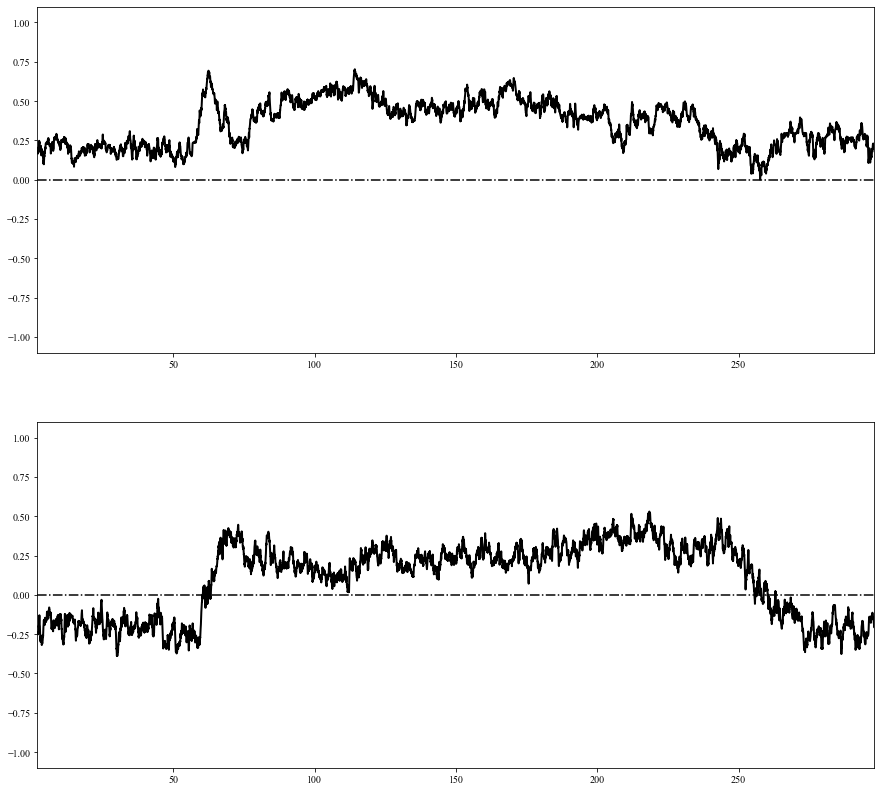

In [187]:
fig, ax = plt.subplots(2,1,figsize=(15,14))

x = np.arange(0,len(m_phi1)-100)/700
cil = cil_phi1
ciu = ciu_phi1

# # plt.plot(x,v[:-100],color='k', lw=2, alpha=.6)

# for i in np.arange(len(stims_stimlist)):
#     up_idx = np.where(ma.diff(stims_stimlist[i]) == 1)[0]
#     down_idx = np.where(ma.diff(stims_stimlist[i]) == -1)[0]
#     ax[0].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#     ax[0].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

#     ax[1].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#     ax[1].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)
#     ax.scatter(np.arange(len(phi2s_stimlist[i][:-100]))/700, phi2s_stimlist[i][:-100], marker = 'o', 
#                c = clusters_stimlist[i][:-100],cmap ='jet', alpha=0.0015,vmin = 0, zorder=0)
#     ax.plot(np.arange(len(phi2s_stimlist[i][:-100]))/700, phi2s_stimlist[i][:-100],color='k', alpha=0.1, ls='--',lw=2, zorder=0)

ax[0].plot(x,m_phi1[:-100],color='k', lw=2, alpha=1., zorder=10)
ax[1].plot(x,m_phi2[:-100],color='k', lw=2, alpha=1., zorder=10)

# ax[0].fill_between(np.arange(0,len(m_phi1)-100)/700, cil_phi1[:-100], ciu_phi1[:-100], color='k', alpha=0.3, zorder=10)
# ax[1].fill_between(np.arange(0,len(m_phi2)-100)/700, cil_phi2[:-100], ciu_phi2[:-100], color='k', alpha=0.3, zorder=10)


# ax.fill_between(np.arange(0,len(m_phi2))/700/60, to_plot[split_idx]*np.ones(len(m_phi2)), np.ones(len(m_phi2)), color = 'b', alpha=0.2)
# ax.fill_between(np.arange(0,len(m_phi2))/700/60, -1*np.ones(len(m_phi2)),to_plot[split_idx]*np.ones(len(m_phi2)), color = 'r', alpha=0.2)

# ax[0].axhline(to_plot[split_idx_phi2],color='k',ls='-.')
ax[0].axhline(0,color='k',ls='-.')
ax[0].set_ylim(-1.1,1.1)
# ax[0].set_xlim(2,148)
# ax[1].axhline(to_plot[split_idx_phi3],color='k',ls='-.')
ax[1].axhline(0,color='k',ls='-.')
ax[1].set_ylim(-1.1,1.1)
ax[0].set_xlim(2,298)
ax[1].set_xlim(2,298)
# ax[1].set_xlim(2,148)

plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl10/Lightdark_meanresp.pdf')

In [188]:
condition_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[cond_recs]

In [189]:
print(np.unique(tmspace_clusters))

[0 3 4 5 6]


0
1109941 1319976
0
(200017,)
(210035,)
1106252 1316292
1
(203706,)
(210040,)
1100634 1310671
3
(209324,)
(210037,)
1100563 1310599
5
(209395,)
(210036,)
(46, 210038)
5
1101337 1311373
1
(208621,)
(210036,)
(29, 210047)
6
1103125 1313060
0
(206833,)
(209935,)
1107906 1317942
1
(202052,)
(210036,)
1101744 1311780
2
(208214,)
(210036,)
(17, 210039)


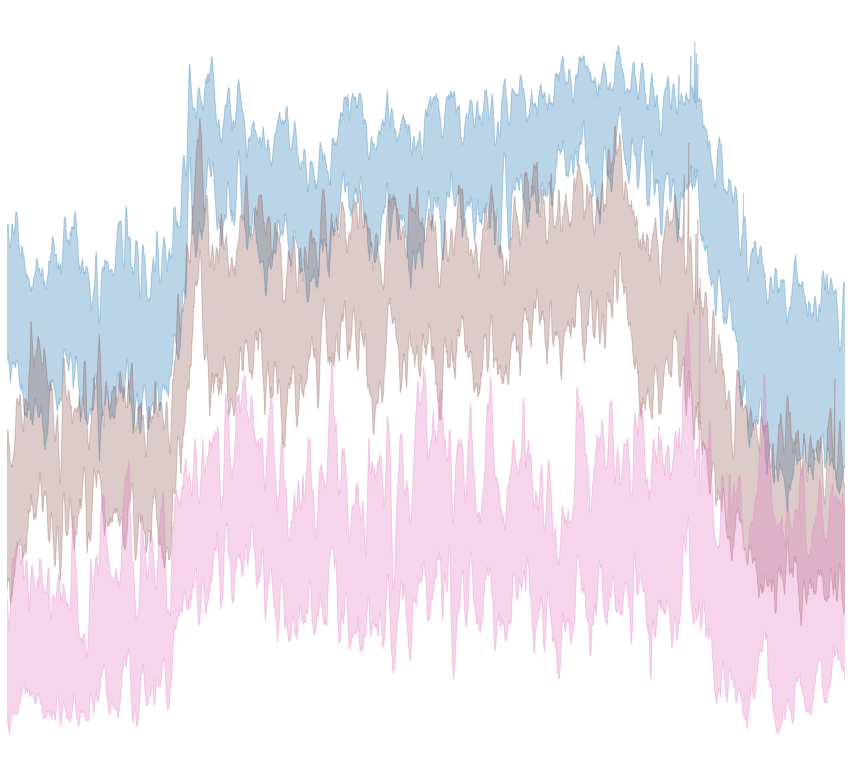

In [192]:
fig, ax = plt.subplots(1,1,figsize=(15,14))
# colors_ = plt.cm.viridis(np.linspace(0,1,len(dir2stim_group)))

stim_number = 1.

from scipy import signal

for clus in [0,5,6]:
    print(clus)
    cluster_idx = np.where(tmspace_clusters == clus)[0]
    phi1s_stimlist = []
    phi2s_stimlist = []
    clusters_stimlist = []
    stims_stimlist = []
    for i, rec in enumerate(cluster_idx):
        sel = stim_number_time[rec] == stim_number
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        if len(segments) == 0:
            continue
        sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]

        for idx in sorted_indices[:]:
            st,en = segments[idx]
#             print((en - st)/700)

#             if (en-st)/700 <19 or (en-st)/700 > 22:
#                 print(i, (en-st)/700)
#                 continue

            win_start = 60*700
    #         st = en - win_start
            win_end = 60*700

            dur_stim = en - st
            dur_tot = (en+win_end) - (st-win_start)

            ss_ = np.zeros((dur_tot,))
            ss_[win_start:win_start+(dur_stim)] = 1.
    #         ss_[0:dur_stim] = 1.

            st = st-win_start
            en = en+win_end

            phi1s = dtrajs_fish_phi1_time[rec][st:en]
            phi2s = dtrajs_fish_phi2_time[rec][st:en]

#                 psi2s = psi2_fish_condition_time[rec][st:en]
#                 psi3s = psi3_fish_condition_time[rec][st:en]
            if phi1s.shape[0] != ss_.shape[0]:
                print(st, en)
                print(i)
                print(phi2s.shape)
                print(ss_.shape)
                continue
            phi1s_stimlist.append(phi1s)
            phi2s_stimlist.append(phi2s)
            stims_stimlist.append(ss_)
            sts = cluster_fish_condition_time[rec][st:en]

    phi1s_stimarr = ma.zeros((len(phi1s_stimlist), np.max([len(p) for p in phi1s_stimlist])))
    phi2s_stimarr = ma.zeros((len(phi2s_stimlist), np.max([len(p) for p in phi2s_stimlist])))
    print(phi1s_stimarr.shape)
    
    # Windowed averaging if needed

    win = np.ones((1*700,))/(1*700)
    for i,p in enumerate(phi1s_stimlist):
        if len(p.compressed()) == 0:
            continue
        phi1s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')
        phi1s_stimarr[i,len(p.compressed()):] = ma.masked

    for i,p in enumerate(phi2s_stimlist):
        if len(p.compressed()) == 0:
            continue
        phi2s_stimarr[i, :len(p)] = signal.convolve(p,win, mode='same',method='fft')
        phi2s_stimarr[i,len(p.compressed()):] = ma.masked

#     for i,p in enumerate(phi1s_stimlist):
#         phi1s_stimarr[i, :len(p)] = p

#     for i,p in enumerate(phi2s_stimlist):
#         phi2s_stimarr[i, :len(p)] = p

    m_phi1, cil_phi1, ciu_phi1 = stats.bootstrap(phi1s_stimarr, n_times = 100)
    m_phi2, cil_phi2, ciu_phi2 = stats.bootstrap(phi2s_stimarr, n_times = 100)

#     from matplotlib.collections import LineCollection
    # divnorm = plt.Normalize(-1,1)

    x = np.arange(700,len(m_phi2)-700)/700
    
#     if clus == 0:
#         ax[0].plot(x,m_phi1[700:-700],color='limegreen', lw=2, alpha=1.)#, zorder=10)
#         ax[1].plot(x,m_phi2[700:-700],color='limegreen'.format(clus), lw=2, alpha=1.)#, zorder=10)
#         ax[0].fill_between(np.arange(700,len(m_phi1)-700)/700, cil_phi1[700:-700].compressed(), ciu_phi1[700:-700].compressed(), color='limegreen', alpha=0.3)#, zorder=10)
#         ax.fill_between(np.arange(700,len(m_phi2)-700)/700, cil_phi2[700:-700].compressed(), ciu_phi2[700:-700].compressed(), color='limegreen', alpha=0.3)#, zorder=10)
#     else:
#     ax[0].plot(x,m_phi1[700:-700],color='C{}'.format(clus), lw=2, alpha=1.)#, zorder=10)
#     ax[1].plot(x,m_phi2[700:-700],color='C{}'.format(clus), lw=2, alpha=1.)#, zorder=10)
#     ax.fill_between(np.arange(700,len(m_phi1)-700)/700, cil_phi1[700:-700], ciu_phi1[700:-700], color='C{}'.format(clus), alpha=0.3)#, zorder=10)
    ax.fill_between(np.arange(700,len(m_phi2)-700)/700, cil_phi2[700:-700], ciu_phi2[700:-700], color='C{}'.format(clus), alpha=0.3)#, zorder=10)


#     for i in np.arange(1):
#         up_idx = np.where(ma.diff(stims_stimlist[i]) == 1)[0]
#         down_idx = np.where(ma.diff(stims_stimlist[i]) == -1)[0]
#         ax[0].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#         ax[0].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

#         ax[1].axvline(up_idx/700,alpha=0.1,ls='--',lw=5)
#         ax[1].axvline(down_idx/700,alpha=0.1, ls='--',lw=5)

# ax[0].plot(x,np.zeros(x.shape),color='k',ls='-.')
# ax[1].plot(x,np.zeros(x.shape),color='k',ls='-.')

# ax[0].axhline(0,color='k',ls='-.')
# ax[0].set_ylim(-1.1,1.1)
ax.set_xlim(2,298)
ax.axis('off')
# ax[1].axhline(0,color='k',ls='-.')
# ax[1].set_ylim(-1.1,1.1)
# ax[1].set_xlim(2,298)
# ax[1].axis('off')
# fig.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl10/lightdark_resp.pdf')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl10/lightdark_resp_phi2.png', dpi=300)